In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling
from src.projects.eurosat.architecture import FCNNetwork, CNNNetwork

/Users/gianrond/miniforge3/envs/tensorflow_ml/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('eurosat')
tensorboard_logdir = Path(os.getcwd()) / Path('trained_models') / Path('tensorboard_logs') / Path('eurosat')

In [8]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:75%]", "train[75%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

In [4]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

In [59]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(img)
        ax.set_title(label)
    plt.show()


2022-12-02 20:10:47.159799: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 20:10:47.203779: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


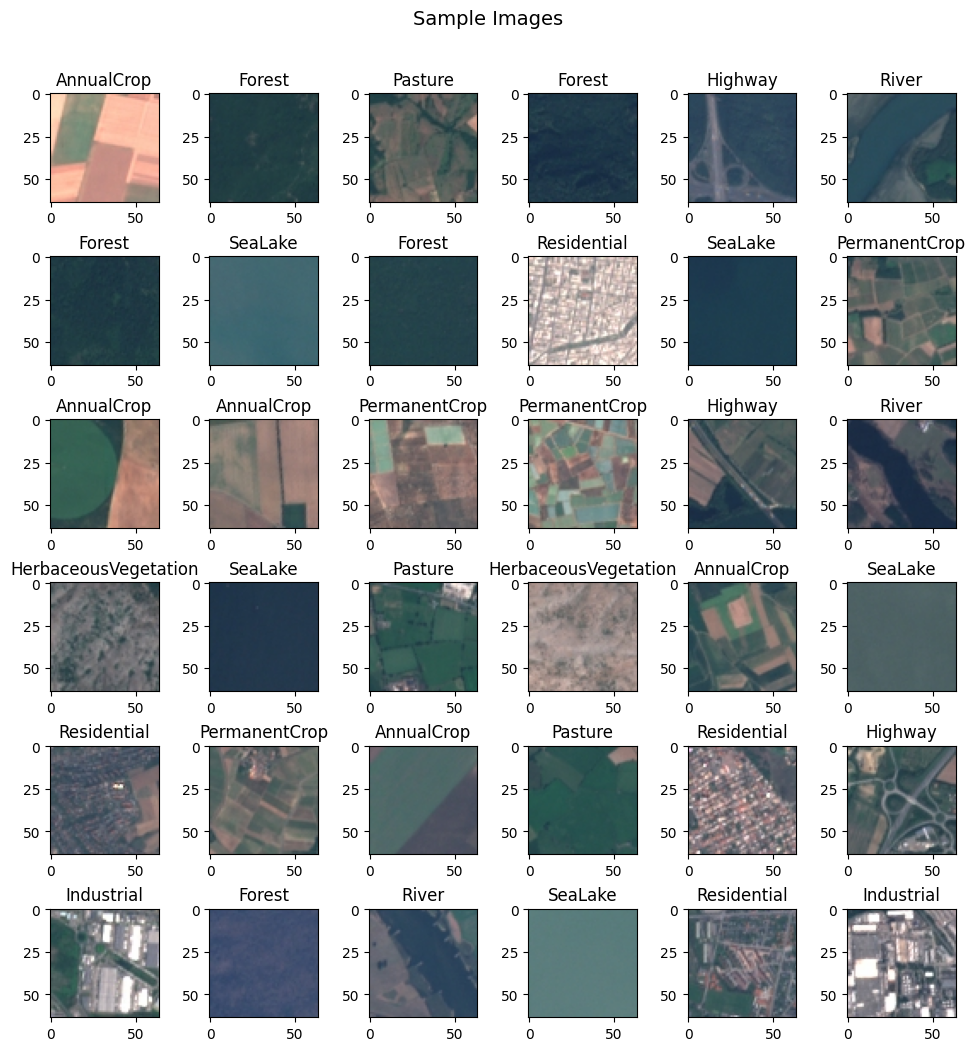

In [6]:
plot_random_images(train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Since all images have the same size we don't need to crop or resize them

2022-12-02 20:10:48.747071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


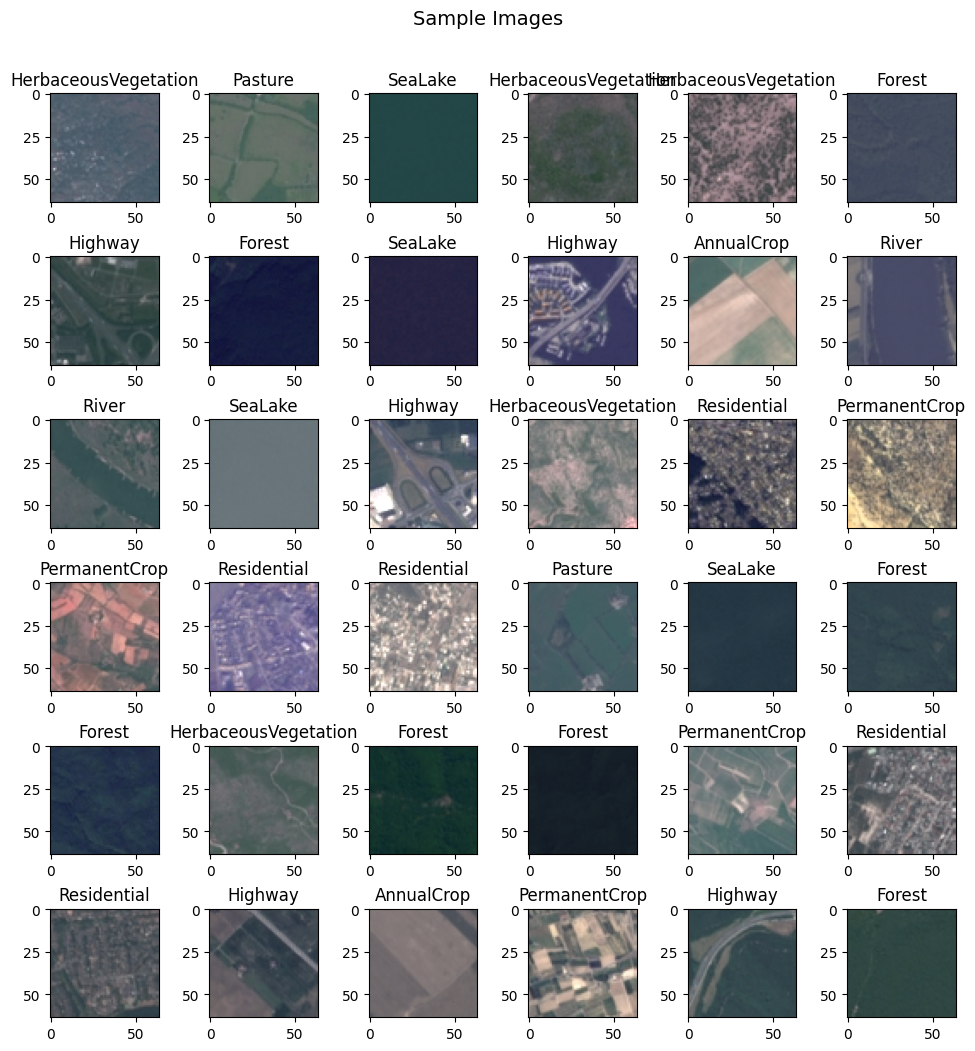

In [7]:
train_dataset = train_dataset.map(lambda image, label: (augmentation(image), label))
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

In [8]:
batch_size = 64
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

We will now train two similar models, one that has a final Dense layer ('CNNNetwork'), and another that is a fully connected CNN network where the final output layer is also a convolutional one, with a Global Max Pooling layer

In [2]:
name = 'CNNNetwork'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name)
model = CNNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(str(tensorboard_run_path)),
    steps_per_epoch=1200,
    validation_steps=1200,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

NameError: name 'model_save_fp' is not defined

In [9]:
name = 'FCNNetwork'
artifacts_path = model_save_fp / Path(name)
tensorboard_run_path = tensorboard_logdir / Path(name)
model = FCNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(str(tensorboard_run_path)),
    steps_per_epoch=1200,
    validation_steps=1200,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "FCNNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    2432      
                                                                 
 batch_normalization (BatchN  (None, None, None, 32)   128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, None, 32)    0         
                                                                 
 dropout (Dropout)           (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                      

2022-12-02 20:10:56.921392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1198/1200 [============================>.] - ETA: 0s - loss: 1.2168 - accuracy: 0.5738

2022-12-02 20:11:20.043315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1200/1200 [==============================] - 36s 29ms/step - loss: 1.2167 - accuracy: 0.5738 - val_loss: 1.4755 - val_accuracy: 0.5376 - lr: 0.0010
Epoch 2/100
1200/1200 [==============================] - 34s 28ms/step - loss: 0.9177 - accuracy: 0.6814 - val_loss: 1.3299 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 3/100
1200/1200 [==============================] - 34s 28ms/step - loss: 0.8005 - accuracy: 0.7221 - val_loss: 1.2138 - val_accuracy: 0.6030 - lr: 0.0010
Epoch 4/100
1200/1200 [==============================] - 34s 28ms/step - loss: 0.7263 - accuracy: 0.7473 - val_loss: 1.3081 - val_accuracy: 0.5559 - lr: 0.0010
Epoch 5/100
1200/1200 [==============================] - 34s 29ms/step - loss: 0.6805 - accuracy: 0.7645 - val_loss: 1.5012 - val_accuracy: 0.4670 - lr: 0.0010
Epoch 6/100
1200/1200 [==============================] - 34s 28ms/step - loss: 0.6386 - accuracy: 0.7793 - val_loss: 1.8481 - val_accuracy: 0.4161 - lr: 0.0010
Epoch 7/100
1200/1200 [=============================

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/FCNNetwork/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/eurosat/FCNNetwork/assets


Now that the models have been trained, we can check the performance of both of them against the test set

In [9]:
test_dataset = test_dataset.map(lambda image, label: (scaling(image), label))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
model_paths = {
    'FCNNetwork': model_save_fp / Path('FCNNetwork'),
    'CNNNetwork': model_save_fp / Path('CNNNetwork'),
}
loaded_models = {}
for model_name, model_path in model_paths.items():
    loaded_models[model_name] = tf.keras.models.load_model(model_path)

*** Model: FCNNetwork ***
85/85 [==============================] - 1s 6ms/step


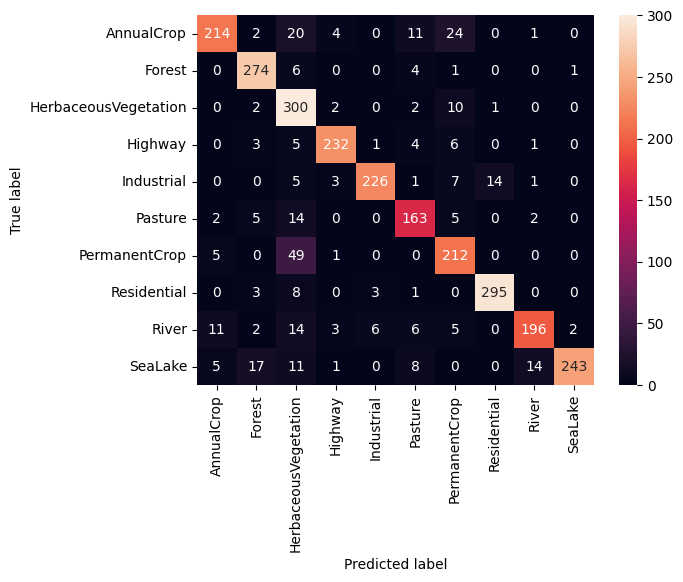

              precision    recall  f1-score   support

           0       0.90      0.78      0.83       276
           1       0.89      0.96      0.92       286
           2       0.69      0.95      0.80       317
           3       0.94      0.92      0.93       252
           4       0.96      0.88      0.92       257
           5       0.81      0.85      0.83       191
           6       0.79      0.79      0.79       267
           7       0.95      0.95      0.95       310
           8       0.91      0.80      0.85       245
           9       0.99      0.81      0.89       299

    accuracy                           0.87      2700
   macro avg       0.88      0.87      0.87      2700
weighted avg       0.88      0.87      0.87      2700

*** Model: CNNNetwork ***
85/85 [==============================] - 0s 5ms/step


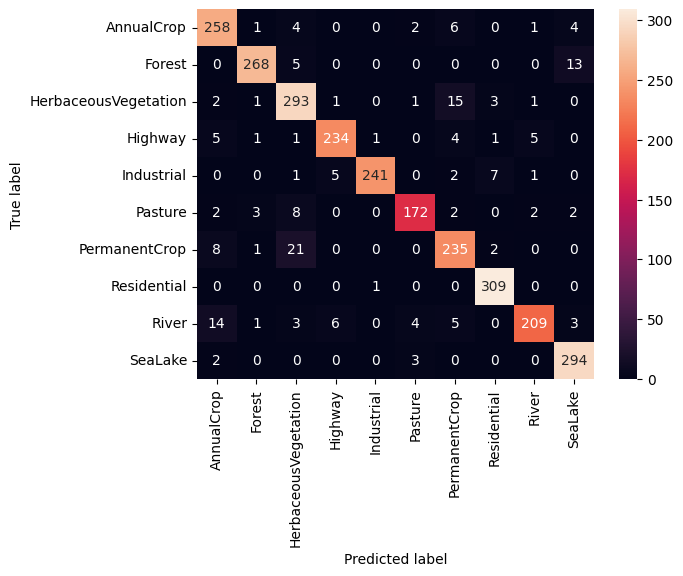

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       276
           1       0.97      0.94      0.95       286
           2       0.87      0.92      0.90       317
           3       0.95      0.93      0.94       252
           4       0.99      0.94      0.96       257
           5       0.95      0.90      0.92       191
           6       0.87      0.88      0.88       267
           7       0.96      1.00      0.98       310
           8       0.95      0.85      0.90       245
           9       0.93      0.98      0.96       299

    accuracy                           0.93      2700
   macro avg       0.93      0.93      0.93      2700
weighted avg       0.93      0.93      0.93      2700

{'FCNNetwork': [0.45274844765663147, 0.8722222447395325], 'CNNNetwork': [0.22356382012367249, 0.9307407140731812]}


In [27]:
accuracies = {}
y_test = np.array(list(test_dataset.map(lambda x, y: y).unbatch().as_numpy_iterator()))
for model_name, model in loaded_models.items():
    print(f'*** Model: {model_name} ***')
    accuracies[model_name] = model.evaluate(test_dataset)
    y_pred = model.predict(test_dataset)
    y_pred_argmax = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred_argmax)
    plt.figure()
    plot = sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    title = f"Confusion matrix - {model_name}"
    plot.set_title('')
    plot.set_xlabel('Predicted label')
    plot.set_ylabel('True label')
    plt.show()

    cr = classification_report(y_test, y_pred_argmax)
    print(cr)
print(accuracies)

The accuracy on the test set confirms what we have seen on the validation data: the CNN-Network outperforms the FCN Network in this case, achieving 93% and 87% accuracy respectively.

Both models seem to have the hardest time to distinguish the "Herbaceous Vegetation" from the "Permanent Crop". It's likely that humans would also have a hard time to tell the two classes apart.

Below are same samples from the two classes:

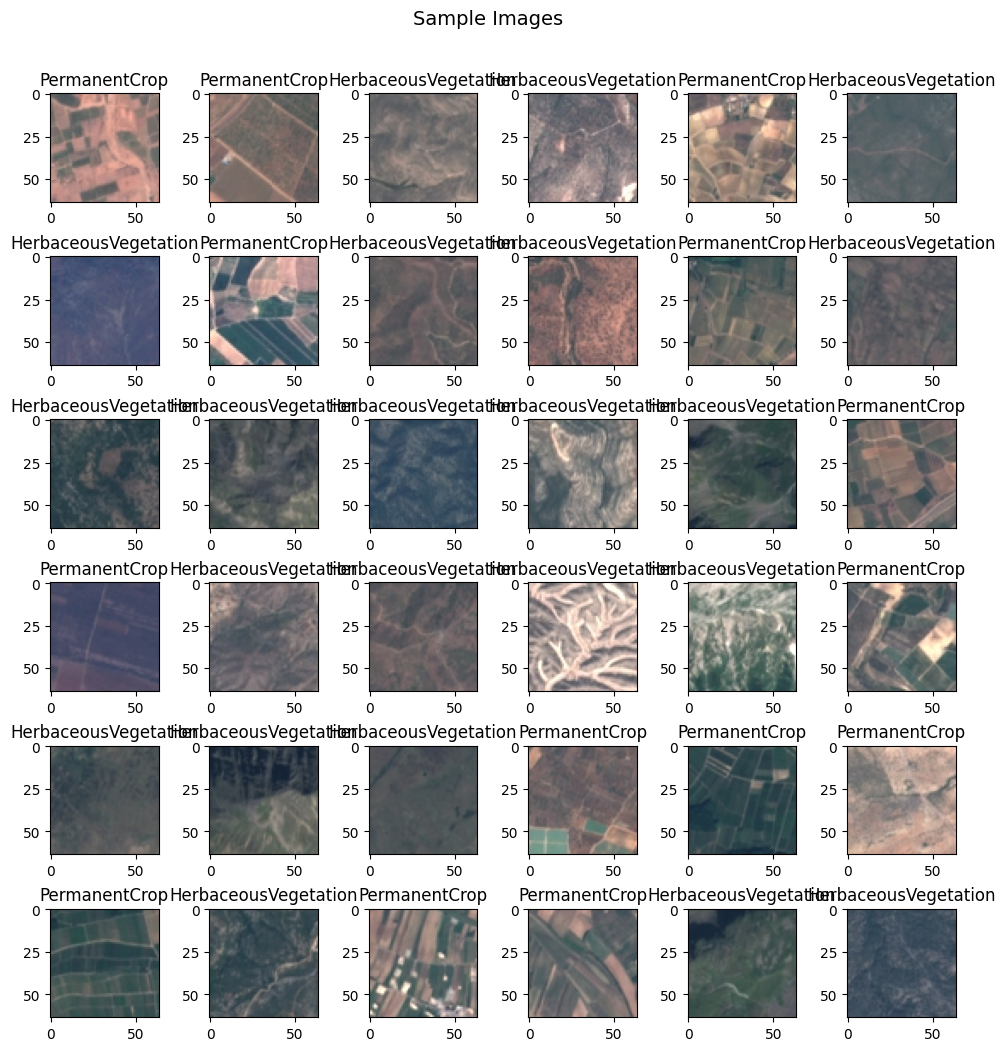

In [73]:
def filter_classes(y_label, y_labels_to_keep):
    return tf.cond(
        tf.math.reduce_any(tf.math.equal(y_label, tf.constant(y_labels_to_keep, dtype=tf.int64))),
        lambda: True,
        lambda: False,
    )
filtered_test_ds = test_dataset.unbatch().filter(lambda x, y: filter_classes(y, [2, 6]))
plot_random_images(filtered_test_ds, 36)

The picture above shows the most two classes that the CNNNetwork model seems to confuse the most. Still, out of the 267 PermanentCrop samples, 235 are correctly labelled. Out of the remaining 32 errors, 21 are (wrongly) attributed to the HerbaceousVegetation class.

It's finally worth reminding, that nor of the two models has been gridsearched and fine tuned to achieve the best performance, so it's likely that there is still room for improvement.